In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import time
import shapefile
import scipy.stats as stats
%matplotlib inline

In [2]:
#Load the dataframe
df = pd.read_csv('/Users/TCummings03/Desktop/Viz')

In [3]:
df = df.drop('Unnamed: 0', axis=1)

In [4]:
df['price_per_sqft'] = df['rent_price']/df.sqft #Create price per square foot column

In [5]:
#Create df for visualization
part1 = df[['price_per_sqft', 'sqft', 'rent_price', 'lats', 'longs', 'neighborhoods']]

part2 = df.iloc[:,1427:-2]

In [6]:
viz = pd.concat([part1,part2], axis=1)

In [7]:
viz.head()

,price_per_sqft,sqft,rent_price,lats,longs,neighborhoods,Accokeek,Adamstown,Alcova Heights,Aldie,...,West River,West Springfield,Westover,Wheaton,White Plains,Williamsburg,Woodbine,Woodbridge,Woodmont Triangle,Yorktown
0,1.702586,1160.0,1975,38.8180,-77.1479,Lincolnia,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2.139806,515.0,1102,38.7434,-77.4669,Manassas,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.546006,989.0,1529,38.8194,-76.9922,Oxon Hill,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1.313448,989.0,1299,38.8387,-76.9098,Suitland,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1.589520,916.0,1456,39.1289,-77.1941,Gaithersburg,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
#This drops neighborhoods that have less than 10 observations

less_than_10 = []

for c in part2.columns:
    
    c_series = part2[c] 

# check to see if value appears less than 10 times
    if np.count_nonzero(c_series) < 10:
        less_than_10.append(c)

part2.drop(less_than_10, axis=1, inplace=True)


In [9]:
#Gets indices from each element of less_than_10

indices = []

for hood in less_than_10:
    indices.append(viz.loc[viz[hood] == 1].index)

In [10]:
#Drop observations with less than 10
flat_list = [item for sublist in indices for item in sublist] #delist
viz = viz.drop(flat_list)

In [11]:
#Median sqft rent price by neighborhood
median_sqft_price = viz.groupby('neighborhoods')['price_per_sqft'].agg('median')

In [12]:
#long/lat for each neighborhood
mean_lats = viz.groupby('neighborhoods')['lats'].agg('mean')
mean_longs = viz.groupby('neighborhoods')['longs'].agg('mean')

In [13]:
#Create decile bins and deciles for median sqft price
bins = ['10th', '20th', '30th', '40th', '50th', '60th', '70th', '80th', '90th', '100th']

deciles = pd.qcut(median_sqft_price, 10, labels=bins)

In [14]:
tiles = []

for hood in viz.neighborhoods:
    tiles.append(deciles.get(hood))

In [15]:
#Add deciles to df
viz['deciles'] = tiles 

In [16]:
#Create a dictionary to encode deciles, so they organize by group in bokeh legend
bins1 = {'10th':1, '20th':2, '30th':3, '40th':4, '50th':5, 
        '60th':6, '70th':7, '80th':8, '90th':9, '100th':10}

deciles_legend = [bins1[x] for x in viz.deciles]
viz['deciles_legend'] = deciles_legend
viz = viz.sort_values(by='deciles_legend')

In [18]:
#Create dataframe for ColumnDataSource for bokeh

percentiles = deciles.to_dict()
median_sqft_price = median_sqft_price.to_dict()

pvalues = list(percentiles.values())
mvalues = list(median_sqft_price.values())
pkeys = list(percentiles.keys())

df_hoods = pd.DataFrame({'percentiles': pvalues, 'median_ppsqft':mvalues, 
                              'neighborhoods':pkeys, 'mean_longs':mean_longs, 
                         'mean_lats':mean_lats})

In [19]:
#Create list for bokeh legend

deciles_legend2 = [bins1[x] for x in df_hoods.percentiles]

df_hoods['deciles_legend'] = deciles_legend2
df_hoods = df_hoods.sort_values(by='deciles_legend')

In [21]:
#Get county geographic information from bokeh's sample data

from bokeh.sampledata.us_counties import data as counties

#VA counties
va_counties = {
    code: county for code, county in counties.items() if county["state"] == "va"
}

va_county_xs = [county["lons"] for county in va_counties.values()]
va_county_ys = [county["lats"] for county in va_counties.values()]

va_county_names = [county['name'] for county in va_counties.values()]

#MD counties
md_counties = {
    code: county for code, county in counties.items() if county["state"] == "md"
}

md_county_xs = [county["lons"] for county in md_counties.values()]
md_county_ys = [county["lats"] for county in md_counties.values()]

md_county_names = [county['name'] for county in md_counties.values()]

#DC county
dc_counties = {
    code: county for code, county in counties.items() if county["state"] == "dc"
}

dc_county_xs = [county["lons"] for county in dc_counties.values()]
dc_county_ys = [county["lats"] for county in dc_counties.values()]

dc_county_names = [county['name'] for county in dc_counties.values()]


In [93]:
# Import the necessary modules
from bokeh.io import output_notebook, show
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.plotting import figure
output_notebook()

# Create a list of county longitudes
x1 = va_county_xs
x2 = md_county_xs
x3 = dc_county_xs

# Create a list of county latitudes
y1 = va_county_ys 
y2 = md_county_ys
y3 = dc_county_ys

#County Names
county_names = va_county_names + md_county_names + dc_county_names

#Create ColumnDataSources
source3 = ColumnDataSource(data=dict(
    x=x1,
    y=y1,
    name=va_county_names
))

source4 = ColumnDataSource(data=dict(
    x=x2,
    y=y2,
    name=md_county_names
))

source5 = ColumnDataSource(data=dict(
    x=x3,
    y=y3,
    name=dc_county_names
))

source_loc = ColumnDataSource(data={
    'x'       : df_hoods.mean_longs,
    'y'       : df_hoods.mean_lats,
    'percentiles' : df_hoods.percentiles,
    'median ppsqft'  : df_hoods.median_ppsqft,
    'hoods'   : df_hoods.neighborhoods,
})

# Save the minimum and maximum values of the longitude column: xmin, xmax
xmin, xmax = min(mean_longs), max(mean_longs)

# Save the minimum and maximum values of the latitude column: ymin, ymax
ymin, ymax = min(mean_lats), max(mean_lats)

# Create the figure: p
p = figure(plot_height=500, plot_width=800,
              x_range=(xmin, xmax), y_range=(ymin, ymax))

# Make a list of the unique values of deciles: deciles_list
deciles_list = bins

# Import CategoricalColorMapper from bokeh.models and the RdBu10 palette from bokeh.palettes
from bokeh.models import CategoricalColorMapper
from bokeh.palettes import RdBu10 as palette

# Make a color mapper: color_mapper
color_mapper = CategoricalColorMapper(palette=palette, factors=deciles_list )

# Add the color mapper to the circle glyph
Circle = p.circle(x='x', y='y', fill_alpha=0.8, source=source_loc,
            color=dict(field='percentiles', transform=color_mapper), 
            legend='percentiles', size=15)

#Add HoverTool
hover = HoverTool(renderers= [Circle], tooltips=[('Median PricePerSqft ($)', '@{median ppsqft}'),
                            ('Locality', '@hoods')])

p.add_tools(hover)

#Regular Blue patches (State boundaries)

VA = p.patches('x','y', line_color='blue', fill_alpha = 0.025, line_width = 0.5, source=source3)
hover1 = HoverTool(renderers=[VA], tooltips=[('County(VA)', '@name')])
p.add_tools(hover1)
MD = p.patches('x','y', line_color='red', fill_alpha=0.025, line_width = 0.5, source=source4)
hover2 = HoverTool(renderers=[MD], tooltips=[('County(MD)', '@name')])
p.add_tools(hover2)
DC = p.patches('x','y', line_color='black', fill_alpha=0.025, line_width = 0.5, source=source5)
hover3 = HoverTool(renderers=[DC], tooltips=[('County(DC)', '@name')])
p.add_tools(hover3)

# Set the legend.location attribute of the plot to 'top_right'
p.legend.location = 'top_right'

#Style plot(label axis, title, etc.)
p.xgrid.visible = False
p.ygrid.visible = False
p.xaxis.axis_label = 'Longitude'
p.yaxis.axis_label = 'Latitude'
p.title.text = 'DC Area Median Sqft Price (Labeled by Decile)'
p.title.align = 'center'
p.title.text_font_size = '25px'

from bokeh.resources import CDN
from bokeh.embed import file_html

html = file_html(p, CDN, "my plot")

#Show plot
show(p)


Loading BokehJS ...

In [34]:
#Visualize most expensive neighborhoods and least expensive neighborhoods
highest_percentiles = viz[viz['deciles'] == '100th']
median_hoods = viz[viz['deciles'] == '50th']
lowest_percentiles = viz[viz['deciles'] == '10th']

In [96]:
highest_percentiles.describe()

,price_per_sqft,sqft,rent_price,lats,longs,Accokeek,Adamstown,Alcova Heights,Aldie,Alexandria,...,West Springfield,Westover,Wheaton,White Plains,Williamsburg,Woodbine,Woodbridge,Woodmont Triangle,Yorktown,deciles_legend
count,1942.000000,1942.000000,1942.000000,1942.000000,1942.000000,1942.0,1942.0,1942.0,1942.0,1942.0,...,1942.0,1942.0,1942.0,1942.0,1942.0,1942.0,1942.0,1942.0,1942.0,1942.0
mean,3.203918,1038.616546,2923.505149,38.908222,-77.063541,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0
std,1.341175,691.443979,1524.784786,0.044285,0.058909,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.509729,120.000000,550.000000,38.536300,-77.599600,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0
25%,2.373958,600.000000,1902.500000,38.897100,-77.076100,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0
50%,2.957515,850.000000,2580.000000,38.910600,-77.050300,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0
75%,3.764706,1239.250000,3450.000000,38.925275,-77.034200,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0
max,12.602578,8035.000000,16000.000000,39.191700,-76.532100,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0


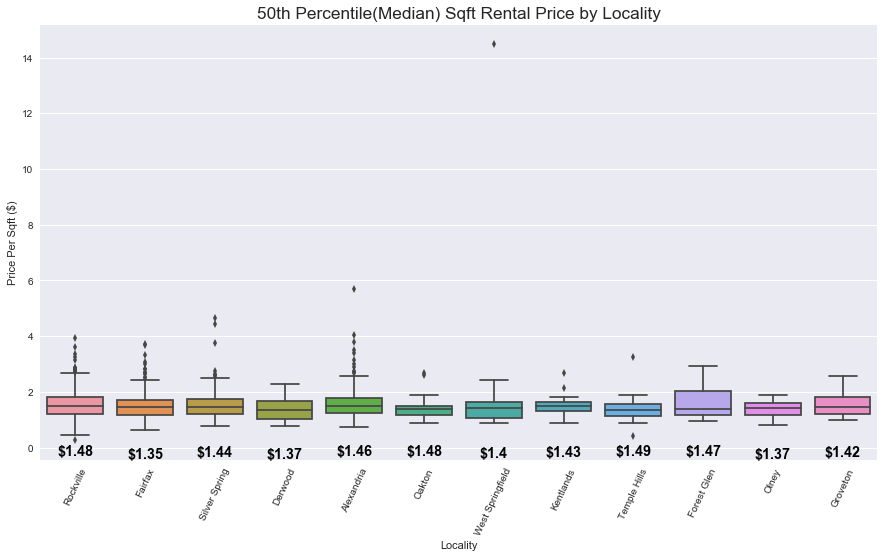

In [62]:
#Sqft Rental Price by Neighborhood
plt.title('50th Percentile(Median) Sqft Rental Price by Locality', size='xx-large')

ax = sns.boxplot(x="neighborhoods", y="price_per_sqft", 
            data=median_hoods)
plt.xticks(rotation=65)

medians = median_hoods.groupby('neighborhoods')['price_per_sqft'].median()
median_labels = [str(np.round(s, 2)) for s in medians]
median_labels = ['$' + x for x in median_labels]
pos = range(len(medians))

for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], medians[tick] -1.75, median_labels[tick], 
            horizontalalignment='center', size='x-large', color='black', weight='semibold')

ax.set_xlabel('Locality')
ax.set_ylabel('Price Per Sqft ($)')
ax.figure.set_size_inches(15,8)


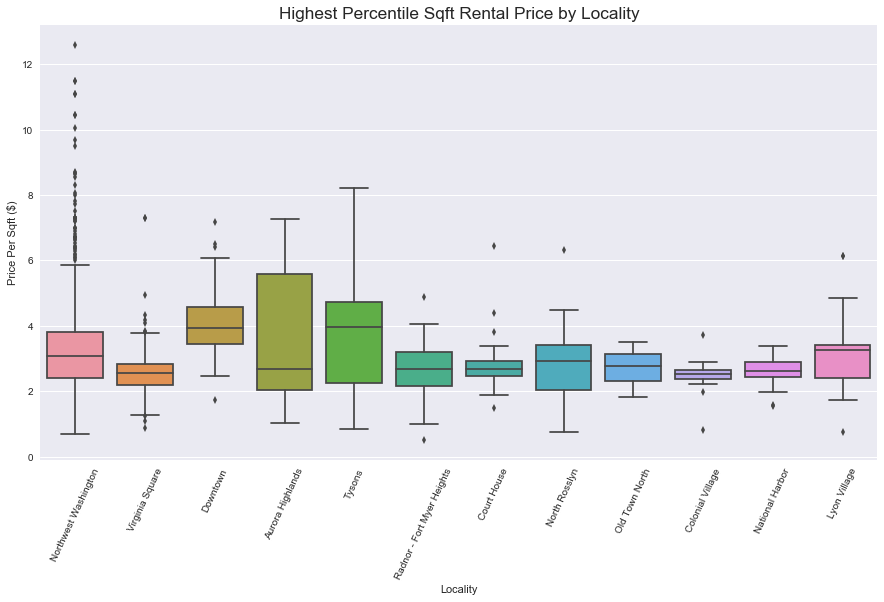

In [65]:
#Sqft Rental Price by Neighborhood
plt.title('Highest Percentile Sqft Rental Price by Locality', size='xx-large')

ax = sns.boxplot(x="neighborhoods", y="price_per_sqft", 
            data=highest_percentiles)
plt.xticks(rotation=65)

ax.set_xlabel('Locality')
ax.set_ylabel('Price Per Sqft ($)')
ax.figure.set_size_inches(15,8)


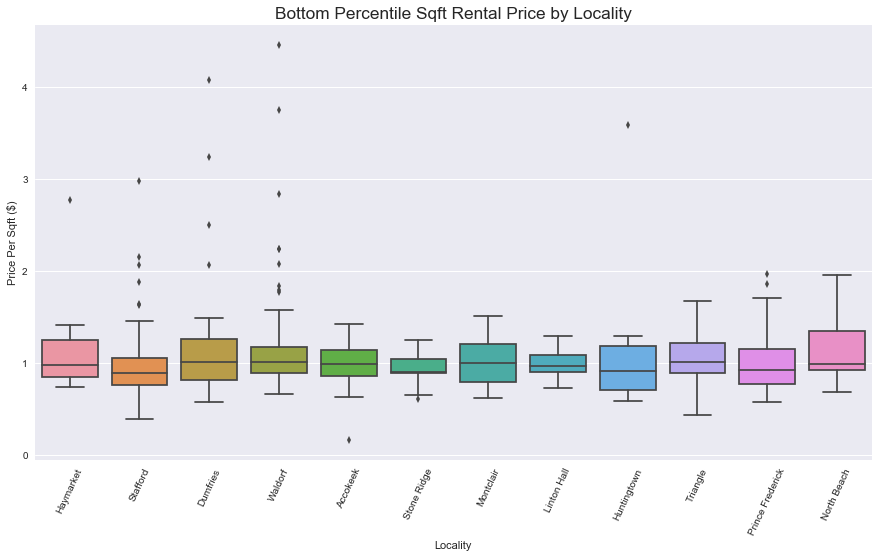

In [26]:
#Sqft Rental Price by Neighborhood
plt.title('Bottom Percentile Sqft Rental Price by Locality', size='xx-large')

ax = sns.boxplot(x="neighborhoods", y="price_per_sqft", 
            data=lowest_percentiles)
plt.xticks(rotation=65)

ax.set_xlabel('Locality')
ax.set_ylabel('Price Per Sqft ($)')
ax.figure.set_size_inches(15,8)


In [27]:
#Here down is up in the air
amenities = df.iloc[:,10:1427]
amenities = pd.concat([df['rent_price'], amenities], axis=1)

In [28]:
corrmat = amenities.corr()

In [29]:
#Get highest and lowest correlations with price
highest_corr = corrmat['rent_price'].nlargest(10)
lowest_corr = corrmat['rent_price'].nsmallest(10)

#Get keys for each group
high_keys = highest_corr.keys()
low_keys = lowest_corr.keys()

#Correlation matrix for each group
high = corrmat.loc[high_keys, high_keys]
low = corrmat.loc[low_keys, low_keys]

In [30]:
corrmat['rent_price'].nsmallest(10)

Playground              -0.118784
Cats Allowed            -0.114260
Air conditioning        -0.108376
Dogs Allowed            -0.108168
Garbage disposal        -0.105530
Carpet                  -0.104982
pool                    -0.104487
Surface lot             -0.102368
Patio or balcony        -0.101729
Public transportation   -0.100453
Name: rent_price, dtype: float64

In [120]:
highest_corr

rent_price        1.000000
Cooktop           0.236818
Zoned A/C         0.201993
Oven - Double     0.196660
Freezer           0.187812
Zoned             0.183401
Ice Maker         0.146912
Vacuum System     0.141407
Exterior Stone    0.139926
Dryer             0.135636
Name: rent_price, dtype: float64

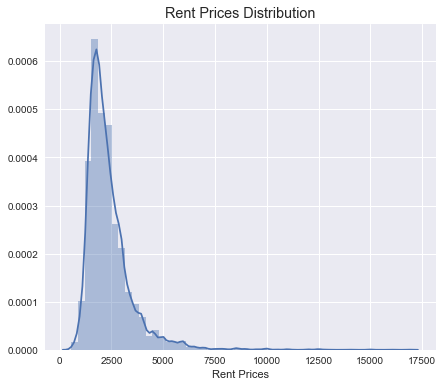

In [83]:
plt.title('Rent Prices Distribution', size='x-large')

ax = sns.distplot(df.rent_price)
ax.figure.set_size_inches(7,6)
ax.set_xlabel('Rent Prices')

In [92]:
part1.iloc[:,:3].describe()

,price_per_sqft,sqft,rent_price
count,10343.000000,10343.000000,10343.000000
mean,1.842098,1561.317910,2365.542976
std,1.058020,937.233172,1148.514460
min,0.160000,110.000000,550.000000
25%,1.159420,885.000000,1659.000000
50%,1.557604,1308.524785,2100.000000
75%,2.193834,2059.918334,2732.500000
max,14.469274,8368.000000,16900.000000


In [99]:
highest_percentiles.price_per_sqft.describe()

count    1942.000000
mean        3.203918
std         1.341175
min         0.509729
25%         2.373958
50%         2.957515
75%         3.764706
max        12.602578
Name: price_per_sqft, dtype: float64

In [100]:
lowest_percentiles.price_per_sqft.describe()

count    532.000000
mean       1.038088
std        0.417909
min        0.160000
25%        0.814009
50%        0.962827
75%        1.160767
max        4.461538
Name: price_per_sqft, dtype: float64

In [101]:
df.price_per_sqft.describe()

count    10343.000000
mean         1.842098
std          1.058020
min          0.160000
25%          1.159420
50%          1.557604
75%          2.193834
max         14.469274
Name: price_per_sqft, dtype: float64

In [106]:
df1 = df.copy()

In [117]:
Downtown = df1[df1['Downtown'] ==1 ]
Tysons = df1[df1['Tysons'] ==1 ]
Northwest_W = df1[df1['Northwest Washington'] ==1 ]

In [127]:
corr_mat = viz.corr

In [136]:
df1.groupby('bedrooms')['rent_price'].median()

bedrooms
0.5     1597.0
1.0     1650.0
2.0     1900.0
3.0     2100.0
4.0     2695.0
5.0     3297.5
6.0     4600.0
7.0     5950.0
8.0    10000.0
9.0     9750.0
Name: rent_price, dtype: float64

In [137]:
df1.groupby('bathrooms')['rent_price'].median()

bathrooms
1.0     1650.0
1.5     1650.0
2.0     2100.0
2.5     2200.0
3.0     2595.0
3.5     2600.0
4.0     2295.0
4.5     3950.0
5.0     3597.5
5.5     5400.0
6.0     4875.0
6.5     7500.0
7.0    10000.0
7.5     6750.0
8.0     6595.0
9.0    11950.0
Name: rent_price, dtype: float64

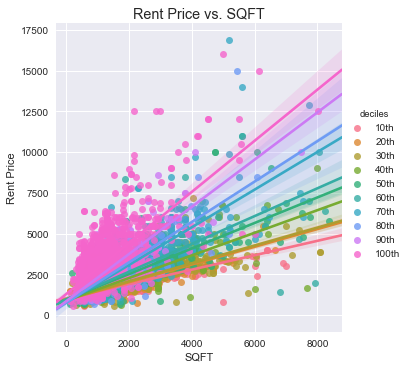

In [150]:
sns.lmplot(x='sqft', y='rent_price', data=viz, hue='deciles')
plt.xlabel('SQFT')
plt.ylabel('Rent Price')
plt.title('Rent Price vs. SQFT', size='x-large')

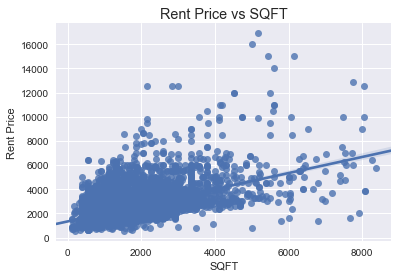

In [151]:
sns.regplot(viz.sqft, viz.rent_price)
plt.xlabel('SQFT')
plt.ylabel('Rent Price')
plt.title('Rent Price vs SQFT', size='x-large')

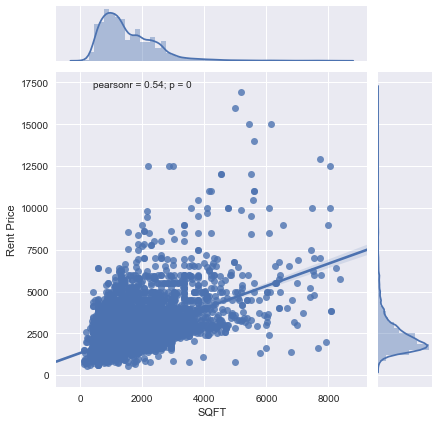

In [153]:
sns.jointplot(x='sqft', y='rent_price', data=viz, kind='reg');
plt.xlabel('SQFT')
plt.ylabel('Rent Price')

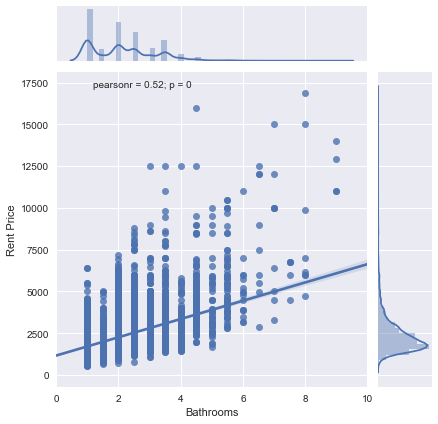

In [158]:
sns.jointplot(x='bathrooms', y='rent_price', data=df1, kind='reg');
plt.xlabel('Bathrooms')
plt.ylabel('Rent Price')

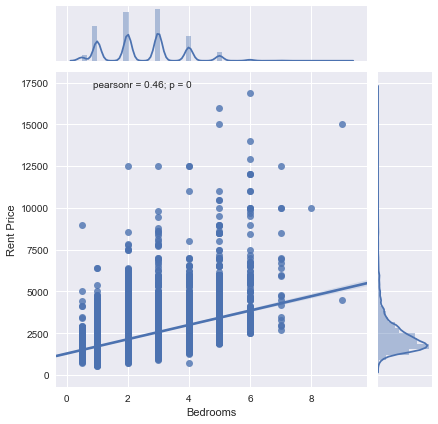

In [157]:
sns.jointplot(x='bedrooms', y='rent_price', data=df1, kind='reg');
plt.xlabel('Bedrooms')
plt.ylabel('Rent Price')

In [175]:
df2 = df1.drop(['listlinks', 'title_address', 
                'lats', 'longs', 'ids', 'amenities', 
                'neighborhoods', 'price_per_sqft'], axis=1)

In [178]:
mat = df2.corr()

In [187]:
mat['rent_price'].nlargest(9)

rent_price              1.000000
sqft                    0.549545
bathrooms               0.515941
bedrooms                0.460794
Cooktop                 0.236818
Northwest Washington    0.203816
Zoned A/C               0.201993
Oven - Double           0.196660
Freezer                 0.187812
Name: rent_price, dtype: float64

In [186]:
mat['rent_price'].nsmallest(9)

Playground         -0.118784
Cats Allowed       -0.114260
Air conditioning   -0.108376
Dogs Allowed       -0.108168
Garbage disposal   -0.105530
Carpet             -0.104982
pool               -0.104487
Surface lot        -0.102368
Patio or balcony   -0.101729
Name: rent_price, dtype: float64